In [ ]:
# !pip install flwr
# !pip install monai
# !pip install kornia

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports and Functions

In [2]:
import os
import sys
import gc
import pickle
import logging
from typing import Tuple, List, Dict, Union, Optional
from collections import defaultdict
from dataclasses import dataclass
import threading
import time

# Environment configuration for GRPC (used by Flower)
os.environ["GRPC_MAX_RECEIVE_MESSAGE_LENGTH"] = "4000000000"
os.environ["GRPC_MAX_SEND_MESSAGE_LENGTH"] = "4000000000"
os.environ["GRPC_DEFAULT_COMPRESSION_ALGORITHM"] = "gzip"

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - [%(filename)s:%(lineno)d] - %(message)s'
)
logger = logging.getLogger(__name__)

# ----------------------------
# PyTorch and Federated Learning
# ----------------------------
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms as T
from torch.amp import autocast, GradScaler # For mixed precision training
# Flower for federated learning coordination
import flwr as fl

# ----------------------------
# Medical Imaging and Inversion Attack Utilities
# ----------------------------
# MONAI: for medical image processing and transformations
import monai

# Kornia: for differentiable computer vision operations (e.g., edge detection)
import kornia
import kornia.enhance
import kornia.losses
# nibabel: for reading/writing medical image formats (e.g., NIfTI)
import nibabel as nib

# ----------------------------
# Data Processing, Evaluation, and Visualization
# ----------------------------
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# scikit-image: for image quality metrics (e.g., SSIM)
from skimage.metrics import structural_similarity as ssim


<frozen importlib._bootstrap_external>:1241: DeprecationWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.


In [3]:
## Medical Classifier
class BrainMRIClassifier(nn.Module):
    def __init__(self):
        super(BrainMRIClassifier, self).__init__()
        self.features = nn.Sequential(
            # First block
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(32),
            # Second block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(64),
            # Third block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(128),
            # Fourth block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(256),
            # Fifth block
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(256),
        )
        # With input size 299x299 and 5 pooling layers, spatial dimensions ~9x9
        self.flat_features = 256 * 9 * 9
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(self.flat_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 4)  # 4 classes
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [4]:
class AttackModel(nn.Module):
    def __init__(self, current_size=64):
        super(AttackModel, self).__init__()
        self.current_size = current_size

        # Simple projection without BatchNorm for the linear layers
        self.projection = nn.Sequential(
            nn.Linear(4, 8 * 8 * 64),
            nn.LeakyReLU(0.2),
            nn.Unflatten(1, (64, 8, 8))
        )

        # Progressive upsampling blocks with GroupNorm instead of BatchNorm
        self.upsampling = nn.ModuleList([
            self._make_block(64, 64),
            self._make_block(64, 32),
            self._make_block(32, 16),
            self._make_block(16, 8)
        ])

        # Detail enhancement
        self.detail = nn.Sequential(
            nn.Conv2d(8, 8, 3, 1, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(8, 8, 3, 1, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(8, 1, 1),
            nn.Tanh()
        )

    def _make_block(self, in_ch, out_ch):
        # Use GroupNorm instead of BatchNorm (works with any batch size)
        return nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_ch, out_ch, 3, 1, 1),
            nn.LeakyReLU(0.2),
            nn.GroupNorm(num_groups=min(8, out_ch), num_channels=out_ch),  # GroupNorm works with batch size 1
            nn.Conv2d(out_ch, out_ch, 3, 1, 1),
            nn.LeakyReLU(0.2),
            nn.GroupNorm(num_groups=min(8, out_ch), num_channels=out_ch)
        )

    def forward(self, x):
        x = self.projection(x)

        # Simple sequential processing
        for block in self.upsampling:
            x = block(x)

        x = self.detail(x)

        # Final resize
        x = F.interpolate(x, size=(self.current_size, self.current_size),
                        mode='bilinear', align_corners=True)

        # Normalize to [0,1]
        return (x + 1) / 2

    def update_size(self, new_size):
        self.current_size = new_size

In [5]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        # Memory-efficient implementation
        reduced_channels = max(in_channels // 8, 8)
        self.query = nn.Conv2d(in_channels, reduced_channels, 1)
        self.key = nn.Conv2d(in_channels, reduced_channels, 1)
        self.value = nn.Conv2d(in_channels, in_channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))

        # Extra feature to enhance edges
        self.edge_enhance = nn.Conv2d(in_channels, in_channels, 3, padding=1, padding_mode='replicate')

    def forward(self, x):
        batch_size, C, H, W = x.size()

        query = self.query(x)
        key = self.key(x)
        value = self.value(x)

        # Reshape for matrix multiplication
        query = query.view(batch_size, -1, H*W).permute(0, 2, 1)
        key = key.view(batch_size, -1, H*W)
        value = value.view(batch_size, -1, H*W)

        # Compute attention scores
        energy = torch.bmm(query, key)
        attention = F.softmax(energy, dim=2)

        # Apply attention to values
        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, H, W)

        # Edge enhancement
        edge_features = self.edge_enhance(x)

        # Combine attention output with edge features
        return self.gamma * out + x + 0.2 * edge_features

In [6]:
class MRIFeatureExtractor(nn.Module):
    def __init__(self):
        super(MRIFeatureExtractor, self).__init__()
        # Use a smaller custom backbone instead of VGG
        # to focus on MRI-specific features
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(32)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(64)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(128)
        )

        # Edge extractor
        self.edge_extractor = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, 1, 1),
            nn.ReLU()
        )

    def forward(self, x):
        # No need to repeat to 3 channels
        feat1 = self.layer1(x)
        feat2 = self.layer2(feat1)
        feat3 = self.layer3(feat2)

        # Extract edges for structure
        edges = self.edge_extractor(x)

        return feat3, edges

In [7]:
## Training Loop Definition

def train_classifier_model(model, train_loader, device, epochs=1):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    total_samples = len(train_loader.dataset)

    for epoch in range(epochs):
        epoch_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_size = images.size(0)
            epoch_loss += loss.item() * batch_size
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_loss = epoch_loss / total
        accuracy = correct / total
        print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Accuracy={accuracy:.4f}")

    return avg_loss, accuracy

def evaluate_model(model, test_loader, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            batch_size = images.size(0)
            total_loss += loss.item() * batch_size
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


In [8]:
## Federated Setup
import flwr as fl

class FLClient(fl.client.NumPyClient):
    def __init__(self, model, train_loader, test_loader, device, epochs=1):
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.device = device
        self.epochs = epochs

    # In FLClient class
    def get_parameters(self):
        return [val.cpu().numpy() for _, val in self.model.state_dict().items()]

    def set_parameters(self, parameters):
        # Load parameters into model.
        params_dict = dict(zip(self.model.state_dict().keys(), parameters))
        state_dict = {k: torch.tensor(v) for k, v in params_dict.items()}
        self.model.load_state_dict(state_dict, strict=True)

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        print("Starting local training...")
        train_loss, train_acc = train_classifier_model(self.model, self.train_loader, self.device, epochs=self.epochs)
        return self.get_parameters(), len(self.train_loader.dataset), {"loss": train_loss, "accuracy": train_acc}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        eval_loss, eval_acc = evaluate_model(self.model, self.test_loader, self.device)
        return float(eval_loss), len(self.test_loader.dataset), {"accuracy": eval_acc}


In [9]:
class FederatedLearningSimulator:
    def __init__(self, model, client_loaders, test_loader, device, num_rounds=5, epochs_per_round=2):
        self.model = model
        self.client_loaders = client_loaders
        self.test_loader = test_loader
        self.device = device
        self.num_rounds = num_rounds
        self.epochs_per_round = epochs_per_round
        self.global_parameters = None
        self.client_models = []  # Store client models for inversion attacks

    def initialize_global_model(self):
        global_model = self.model().to(self.device)
        self.global_parameters = [val.cpu().numpy() for _, val in global_model.state_dict().items()]

    def run_federated_learning(self):
        self.initialize_global_model()
        self.client_models = []  # Reset client models

        for round_num in range(self.num_rounds):
            print(f"\n===== Round {round_num+1}/{self.num_rounds} =====")
            client_parameters = []
            client_weights = []
            round_client_models = []  # Store client models for this round

            # Train on each client
            for client_idx, loader in enumerate(self.client_loaders):
                print(f"\nTraining client {client_idx+1}:")

                # Create new model instance for this client
                client_model = self.model().to(self.device)

                # Load global parameters
                params_dict = dict(zip(client_model.state_dict().keys(), self.global_parameters))
                state_dict = {k: torch.tensor(v) for k, v in params_dict.items()}
                client_model.load_state_dict(state_dict, strict=True)

                # Train the client model with per-epoch validation
                for epoch in range(self.epochs_per_round):
                    train_loss, train_acc = train_classifier_model(client_model, loader, self.device, epochs=1)
                    val_loss, val_acc = evaluate_model(client_model, self.test_loader, self.device)
                    print(f"  Epoch {epoch+1}/{self.epochs_per_round}: Train acc={train_acc:.4f}, Val acc={val_acc:.4f}")

                # Save client model (only from final round)
                if round_num == self.num_rounds - 1:
                    # Create a copy to avoid reference issues
                    client_copy = self.model().to(self.device)
                    client_copy.load_state_dict(client_model.state_dict())
                    round_client_models.append((client_idx, client_copy))

                # Collect client's updated parameters
                params = [val.cpu().numpy() for _, val in client_model.state_dict().items()]
                client_parameters.append(params)
                client_weights.append(len(loader.dataset))

            # Save client models from final round
            if round_num == self.num_rounds - 1:
                self.client_models = round_client_models

            # Perform weighted averaging to update global parameters
            self.global_parameters = self.federated_averaging(client_parameters, client_weights)

            # Evaluate global model after aggregation
            global_model = self.model().to(self.device)
            params_dict = dict(zip(global_model.state_dict().keys(), self.global_parameters))
            state_dict = {k: torch.tensor(v) for k, v in params_dict.items()}
            global_model.load_state_dict(state_dict, strict=True)

            eval_loss, eval_acc = evaluate_model(global_model, self.test_loader, self.device)
            print(f"\n>> Round {round_num+1} complete: Global model accuracy = {eval_acc:.4f}")

        return self.global_parameters

    def federated_averaging(self, client_parameters, client_weights):
        total_weight = sum(client_weights)
        weighted_params = []

        for i in range(len(client_parameters[0])):
            weighted_sum = sum(client_params[i] * weight for client_params, weight
                              in zip(client_parameters, client_weights))
            weighted_params.append(weighted_sum / total_weight)

        return weighted_params

In [10]:
def client_fn(cid: str) -> fl.client.NumPyClient:
    # Convert client id (string) to integer index
    index = int(cid)
    # Create a new instance of the classifier for this client
    model = BrainMRIClassifier().to(device)
    # Use the corresponding client DataLoader and common test_loader as validation
    return FLClient(model, client_loaders[index], test_loader, device, epochs=2)

In [11]:
def run_mri_focused_attack(classifier_model, attack_model, data_loader, feature_extractor, device,
                        training_epochs=25, start_size=32, final_size=299):
    # Get model predictions
    classifier_model.eval()
    all_images = []
    all_predictions = []

    with torch.no_grad():
        for images, _ in data_loader:
            images = images[:8].to(device)
            outputs = classifier_model(images)
            probs = torch.softmax(outputs, dim=1)
            all_images.append(images.cpu())
            all_predictions.append(probs.cpu())

    all_images = torch.cat(all_images, dim=0)[:32]
    all_predictions = torch.cat(all_predictions, dim=0)[:32]

    # Ensure we have at least 2 samples (for BatchNorm)
    if len(all_images) == 1:
        all_images = all_images.repeat(2, 1, 1, 1)
        all_predictions = all_predictions.repeat(2, 1)

    # Progressive training
    sizes = [start_size, int(start_size*1.5), start_size*2, int(start_size*3),
             start_size*4, int(start_size*6), final_size]
    sizes = [size for size in sizes if size <= final_size]

    feature_extractor.eval()
    scaler = GradScaler()

    # Loss weights
    lambda_pixel = 1.0
    lambda_edge = 0.8
    lambda_perceptual = 0.3

    for step, current_size in enumerate(sizes):
        print(f"\nTraining at resolution {current_size}x{current_size} ({step+1}/{len(sizes)})")
        attack_model.update_size(current_size)

        # Resolution-based learning rate
        base_lr = 0.0002 if current_size <= 64 else 0.0001
        if current_size >= 128:
            base_lr *= 0.5

        optimizer = optim.Adam(attack_model.parameters(), lr=base_lr, betas=(0.5, 0.999))

        # Adaptive epochs
        local_epochs = training_epochs
        if current_size >= 128:
            local_epochs = int(training_epochs * 1.5)

        attack_model.train()

        # Ensure minimum batch size of 2 for all resolutions
        batch_size = 4 if current_size <= 64 else 2

        # Use fewer samples for high resolutions
        train_samples = len(all_images)
        if current_size >= 128:
            train_samples = min(16, len(all_images))

        train_images = all_images[:train_samples]
        train_preds = all_predictions[:train_samples]

        for epoch in range(local_epochs):
            total_loss = 0
            batches = 0

            # Clear memory
            torch.cuda.empty_cache()
            gc.collect()

            # Shuffle data each epoch
            indices = torch.randperm(len(train_images))
            shuffle_imgs = train_images[indices]
            shuffle_preds = train_preds[indices]

            for i in range(0, len(shuffle_imgs), batch_size):
                # Clear memory
                torch.cuda.empty_cache()
                gc.collect()

                end_idx = min(i + batch_size, len(shuffle_imgs))
                batch_data = shuffle_imgs[i:end_idx].to(device)
                batch_targets = shuffle_preds[i:end_idx].to(device)

                # Skip if we somehow got a batch of size 1
                if batch_data.size(0) < 2:
                    batch_data = batch_data.repeat(2, 1, 1, 1)
                    batch_targets = batch_targets.repeat(2, 1)

                # Resize to current resolution
                batch_data = F.interpolate(batch_data, size=(current_size, current_size),
                                         mode='bilinear', align_corners=True)

                optimizer.zero_grad()

                with autocast(device_type='cuda'):
                    reconstructed = attack_model(batch_targets)

                    # Basic losses
                    mse_loss = F.mse_loss(reconstructed, batch_data)
                    l1_loss = F.l1_loss(reconstructed, batch_data)

                    # Edge detection
                    sobel_real = kornia.filters.sobel(batch_data)
                    sobel_fake = kornia.filters.sobel(reconstructed)
                    edge_loss = F.l1_loss(sobel_fake, sobel_real)

                    # Feature extraction
                    with torch.no_grad():
                        real_feat, _ = feature_extractor(batch_data)
                    fake_feat, _ = feature_extractor(reconstructed)
                    perceptual_loss = F.mse_loss(fake_feat, real_feat.detach())

                    # Combined loss
                    loss = (lambda_pixel * (mse_loss + 0.5 * l1_loss) +
                           lambda_edge * edge_loss +
                           lambda_perceptual * perceptual_loss)

                # Step with gradient scaling
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(attack_model.parameters(), max_norm=0.5)
                scaler.step(optimizer)
                scaler.update()

                total_loss += loss.item()
                batches += 1

                # Clean up
                del real_feat, fake_feat, sobel_real, sobel_fake
                del loss, mse_loss, l1_loss, edge_loss, perceptual_loss

            # Report progress
            if batches > 0:
                avg_loss = total_loss / batches
                print(f'Epoch {epoch+1}/{local_epochs}: Loss = {avg_loss:.6f}')

    # Generate final output
    attack_model.eval()
    with torch.no_grad():
        subset_size = min(16, len(all_predictions))
        subset_preds = all_predictions[:subset_size].to(device)

        reconstructed_list = []
        for i in range(0, subset_size, 2):
            end_idx = min(i + 2, subset_size)
            batch_preds = subset_preds[i:end_idx].to(device)

            # Duplicate if batch size is 1
            if batch_preds.size(0) == 1:
                batch_preds = batch_preds.repeat(2, 1)

            batch_reconstructed = attack_model(batch_preds)

            # Only keep the first sample if we duplicated
            if end_idx - i == 1:
                batch_reconstructed = batch_reconstructed[:1]

            reconstructed_list.append(batch_reconstructed.cpu())

        reconstructed = torch.cat(reconstructed_list, dim=0).to(device)

        # Apply enhanced post-processing
        try:
            reconstructed = mri_specialized_post_processing(reconstructed)
        except:
            # Fallback to simple post-processing
            reconstructed = torch.clamp(reconstructed * 1.1, 0, 1)

    return reconstructed



# Simple but effective post-processing for MRI images
def advanced_mri_post_processing(images):
    """Advanced post-processing optimized for MRI images"""
    # Convert to CPU for memory efficiency
    images_cpu = images.cpu()

    # Create masks for different regions based on intensity
    bright_mask = (images_cpu > 0.6).float()
    mid_mask = ((images_cpu > 0.3) & (images_cpu <= 0.6)).float()
    dark_mask = (images_cpu <= 0.3).float()

    # Enhanced contrast with region-specific adjustments
    bright_regions = torch.clamp(images_cpu * 1.1, 0, 1) * bright_mask
    mid_regions = torch.clamp(images_cpu * 1.25 - 0.05, 0, 1) * mid_mask
    dark_regions = torch.clamp(images_cpu * 0.9, 0, 1) * dark_mask

    # Combine regions
    contrast_enhanced = bright_regions + mid_regions + dark_regions

    # Edge enhancement
    edges = kornia.filters.sobel(images_cpu)
    edge_enhanced = torch.clamp(images_cpu + 0.3 * edges, 0, 1)

    # Sharpen with unsharp mask
    blurred = kornia.filters.gaussian_blur2d(images_cpu, (5, 5), (1.0, 1.0))
    sharpened = torch.clamp(images_cpu + 0.7 * (images_cpu - blurred), 0, 1)

    # Blend all enhancements with weighted average
    result = 0.3 * contrast_enhanced + 0.3 * edge_enhanced + 0.4 * sharpened
    result = torch.clamp(result, 0, 1)

    # Return to device
    return result.to(images.device)

In [12]:
def evaluate_mri_reconstruction(original, reconstructed):
    """Evaluate MRI reconstruction with focus on anatomical structure"""
    # Make sure both tensors have same dimensions
    if original.shape != reconstructed.shape:
        reconstructed = F.interpolate(
            reconstructed,
            size=original.shape[2:],
            mode='bilinear',
            align_corners=True
        )

    # Standard metrics
    mse, psnr, ssim_val = evaluate_inversion_optimized(original, reconstructed)

    # Edge preservation metric with shape check
    orig_edges = kornia.filters.sobel(original.cpu())
    recon_edges = kornia.filters.sobel(reconstructed.cpu())

    # Verify shapes match before computing similarity
    if orig_edges.shape != recon_edges.shape:
        recon_edges = F.interpolate(
            recon_edges,
            size=orig_edges.shape[2:],
            mode='bilinear',
            align_corners=True
        )

    # Compute similarity only if shapes match
    if orig_edges.shape == recon_edges.shape:
        edge_similarity = F.cosine_similarity(
            orig_edges.flatten(1),
            recon_edges.flatten(1)
        ).mean().item()
    else:
        # Fallback if shapes still don't match
        edge_similarity = 0.5  # Default value

    # Structure preservation metric (approximate)
    structure_score = ssim_val * edge_similarity

    return {
        'MSE': mse,
        'PSNR': psnr,
        'SSIM': ssim_val,
        'Edge_Similarity': edge_similarity,
        'Structure_Score': structure_score
    }

In [13]:
def evaluate_inversion_optimized(original_images, reconstructed_images):
    # Move to CPU before operations to save GPU memory
    original_images = original_images.cpu()
    reconstructed_images = reconstructed_images.cpu()

    # Resize to the same dimensions before comparison
    if original_images.shape[2:] != reconstructed_images.shape[2:]:
        reconstructed_images = F.interpolate(
            reconstructed_images,
            size=original_images.shape[2:],
            mode='bilinear',
            align_corners=True
        )

    # Limit to just a few samples for evaluation if large batch
    if original_images.size(0) > 8:
        original_images = original_images[:8]
        reconstructed_images = reconstructed_images[:8]

    # Convert to NumPy arrays
    orig = original_images.numpy()
    recon = reconstructed_images.numpy()

    # Calculate metrics
    mse = np.mean((orig - recon) ** 2)
    psnr = 20 * np.log10(1.0 / np.sqrt(mse) + 1e-8)  # Add small epsilon to avoid log(0)

    # SSIM on the first sample only
    ssim_val = ssim(orig[0,0,:,:], recon[0,0,:,:], data_range=1.0)

    # Clean up to free memory
    del orig, recon
    torch.cuda.empty_cache()

    return mse, psnr, ssim_val

In [14]:
def evaluate_multiple_reconstructions(classifier_model, attack_model, test_loader, device, num_samples=5):
    classifier_model.eval()
    attack_model.eval()

    # Get test images
    for images, _ in test_loader:
        test_images = images.to(device)
        break

    test_images = test_images[:num_samples]

    with torch.no_grad():
        outputs = classifier_model(test_images)
        predictions = torch.softmax(outputs, dim=1)

        # Process in smaller batches
        reconstructed_list = []
        for i in range(0, len(predictions), 2):
            batch_preds = predictions[i:i+2]
            batch_recon = attack_model(batch_preds)
            reconstructed_list.append(batch_recon)

        reconstructed_images = torch.cat(reconstructed_list, dim=0)
        reconstructed_images = advanced_mri_post_processing(reconstructed_images)

    # Evaluate each image
    metrics = []
    for i in range(num_samples):
        orig = test_images[i:i+1]
        recon = reconstructed_images[i:i+1]
        metrics.append(evaluate_mri_reconstruction(orig, recon))

    return {
        'original': test_images,
        'reconstructed': reconstructed_images,
        'metrics': metrics
    }

In [15]:
## Data Loading Functions
def load_data(images_path, labels_path):
    with open(images_path, 'rb') as f:
        images = pickle.load(f)
    with open(labels_path, 'rb') as f:
        labels = pickle.load(f)
    return images, labels

def prepare_dataset(images, labels):
    # Convert images to NumPy array and then to a float tensor.
    images = torch.tensor(np.array(images)).float()
    # If images are grayscale and shaped (N, H, W), add channel dimension to get (N, 1, H, W)
    if images.ndim == 3:
        images = images.unsqueeze(1)
    # Convert labels to tensor (assuming integer encoding for CrossEntropyLoss)
    labels = torch.tensor(np.array(labels)).long()
    return torch.utils.data.TensorDataset(images, labels)


In [16]:
def load_global_model(path='saved_models/global_model.pth'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = BrainMRIClassifier().to(device)
    model.load_state_dict(torch.load(path, map_location=device))
    return model

def load_client_model(client_idx, path=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if path is None:
        path = f'saved_models/client_{client_idx}_model.pth'
    model = BrainMRIClassifier().to(device)
    model.load_state_dict(torch.load(path, map_location=device))
    return model

def load_attack_model(current_size=299, path='saved_models/attack_model.pth'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = AttackModel(current_size=current_size).to(device)
    model.load_state_dict(torch.load(path, map_location=device))
    return model

In [17]:
def visualize_multiple_reconstructions(results, title="MRI Reconstruction Results"):
    """
    Visualizes multiple original vs reconstructed image pairs

    Args:
        results: Dictionary with original images, reconstructions and metrics
        title: Plot title
    """
    originals = results['original']
    reconstructed = results['reconstructed']
    metrics = results['metrics']

    num_samples = len(metrics)

    plt.figure(figsize=(5*num_samples, 10))
    plt.suptitle(title, fontsize=16)

    for i in range(num_samples):
        # Original image
        plt.subplot(2, num_samples, i+1)
        plt.imshow(originals[i, 0].cpu(), cmap='gray')
        plt.title(f"Original {i+1}")
        plt.axis('off')

        # Reconstructed image
        plt.subplot(2, num_samples, i+1+num_samples)
        plt.imshow(reconstructed[i, 0].cpu(), cmap='gray')
        plt.title(f"Reconstructed {i+1}\nPSNR: {metrics[i]['PSNR']:.2f}, SSIM: {metrics[i]['SSIM']:.4f}")
        plt.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Define Data Paths

###Please modify the paths in below cell to read your data!

In [18]:
DATA_PATHS = {
    "clients": [
        {
            "images": "/content/drive/MyDrive/Spring 25/github_brainfl/data/bench/data_client1.pickle", ## <-Replace
            "labels": "/content/drive/MyDrive/Spring 25/github_brainfl/data/bench/labels_client1.pickle", ## <-Replace
        },
        {
            "images": "/content/drive/MyDrive/Spring 25/github_brainfl/data/bench/data_client2.pickle", ## <-Replace
            "labels": "/content/drive/MyDrive/Spring 25/github_brainfl/data/bench/labels_client2.pickle", ## <-Replace
        },
        {
            "images": "/content/drive/MyDrive/Spring 25/github_brainfl/data/bench/data_client3.pickle", ## <-Replace
            "labels": "/content/drive/MyDrive/Spring 25/github_brainfl/data/bench/labels_client3.pickle", ## <-Replace
        }
    ],
    "test": {
        "images": "/content/drive/MyDrive/Spring 25/github_brainfl/data/bench/test_images.pickle", ## <-Replace
        "labels": "/content/drive/MyDrive/Spring 25/github_brainfl/data/bench/test_labels.pickle" ## <-Replace
    }
}


# Load test/validation dataset (used for all clients and global evaluation)
test_images, test_labels = load_data(DATA_PATHS["test"]["images"], DATA_PATHS["test"]["labels"])
test_dataset = prepare_dataset(test_images, test_labels)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load client datasets (assumes each client's data is pre-split)
client_datasets = []
for client_info in DATA_PATHS["clients"]:
    imgs, labs = load_data(client_info["images"], client_info["labels"])
    ds = prepare_dataset(imgs, labs)
    client_datasets.append(ds)

# Create DataLoaders for each client
client_loaders = [DataLoader(ds, batch_size=32, shuffle=True) for ds in client_datasets]

# Medical Model Training

Note that, you do not have to perform this step since you should already have the trained models in your repository (if you have been following along from the beginning). Alternatively, you can download the pretrained models from the github page under the ```pretrained_models``` folder, and proceed to next block of code.

If you want to re-train the models and save a copy of these models feel free to run the below cells, otherwise please proceed to the ```Main Execution Block```.

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a shared parameters container for manually simulating federated learning


# Create simulator with customizable parameters
fl_simulator = FederatedLearningSimulator(
    model=BrainMRIClassifier,
    client_loaders=client_loaders,
    test_loader=test_loader,
    device=device,
    num_rounds=10,               # Adjustable number of rounds
    epochs_per_round=5          # Adjustable epochs per round
)

# Run federated learning
print("Starting federated learning simulation...")
global_parameters = fl_simulator.run_federated_learning()
print("Federated training simulation completed.")

In [ ]:
os.makedirs('saved_models', exist_ok=True)

# Create and save global model
global_model = BrainMRIClassifier().to(device)
params_dict = dict(zip(global_model.state_dict().keys(), global_parameters))
state_dict = {k: torch.tensor(v) for k, v in params_dict.items()}
global_model.load_state_dict(state_dict, strict=True)

# Save global model
torch.save(global_model.state_dict(), 'saved_models/global_model_bench.pth')

# Save client models
for client_idx, client_model in fl_simulator.client_models:
    torch.save(client_model.state_dict(), f'saved_models/client_{client_idx}_model_bench.pth')

# Main Execution Block

### Global Model

In [20]:
### Run this version if you are loading the models
# Get original images for comparison
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for original_images, _ in test_loader:
    original_images = original_images.to(device)
    break

# Load models

global_model = load_global_model('/content/drive/MyDrive/Spring 25/github_brainfl/pretrained_models/global_model.pth')
feature_extractor = MRIFeatureExtractor().to(device)

# Create or load attack model
attack_model = AttackModel(current_size=32).to(device)

# Run attack on global model
# Run enhanced inversion attack on global model
print("\nRunning inversion attack on Global model...")
global_reconstructed = run_mri_focused_attack(
    global_model,
    attack_model,  # Will use the memory-efficient version
    test_loader,
    feature_extractor,  # Will use the memory-efficient version
    device,
    training_epochs=15,  # Reduced from 30
    start_size=32,
    final_size=299
)




Running inversion attack on Global model...

Training at resolution 32x32 (1/7)
Epoch 1/15: Loss = 0.472756
Epoch 2/15: Loss = 0.413869
Epoch 3/15: Loss = 0.359183
Epoch 4/15: Loss = 0.304222
Epoch 5/15: Loss = 0.257546
Epoch 6/15: Loss = 0.214965
Epoch 7/15: Loss = 0.177944
Epoch 8/15: Loss = 0.149542
Epoch 9/15: Loss = 0.131092
Epoch 10/15: Loss = 0.118358
Epoch 11/15: Loss = 0.113504
Epoch 12/15: Loss = 0.108530
Epoch 13/15: Loss = 0.104928
Epoch 14/15: Loss = 0.103178
Epoch 15/15: Loss = 0.100349

Training at resolution 48x48 (2/7)
Epoch 1/15: Loss = 0.099662
Epoch 2/15: Loss = 0.097277
Epoch 3/15: Loss = 0.096877
Epoch 4/15: Loss = 0.096735
Epoch 5/15: Loss = 0.096965
Epoch 6/15: Loss = 0.097864
Epoch 7/15: Loss = 0.095308
Epoch 8/15: Loss = 0.095776
Epoch 9/15: Loss = 0.095172
Epoch 10/15: Loss = 0.094221
Epoch 11/15: Loss = 0.094988
Epoch 12/15: Loss = 0.094974
Epoch 13/15: Loss = 0.094375
Epoch 14/15: Loss = 0.094864
Epoch 15/15: Loss = 0.094168

Training at resolution 64x64 (

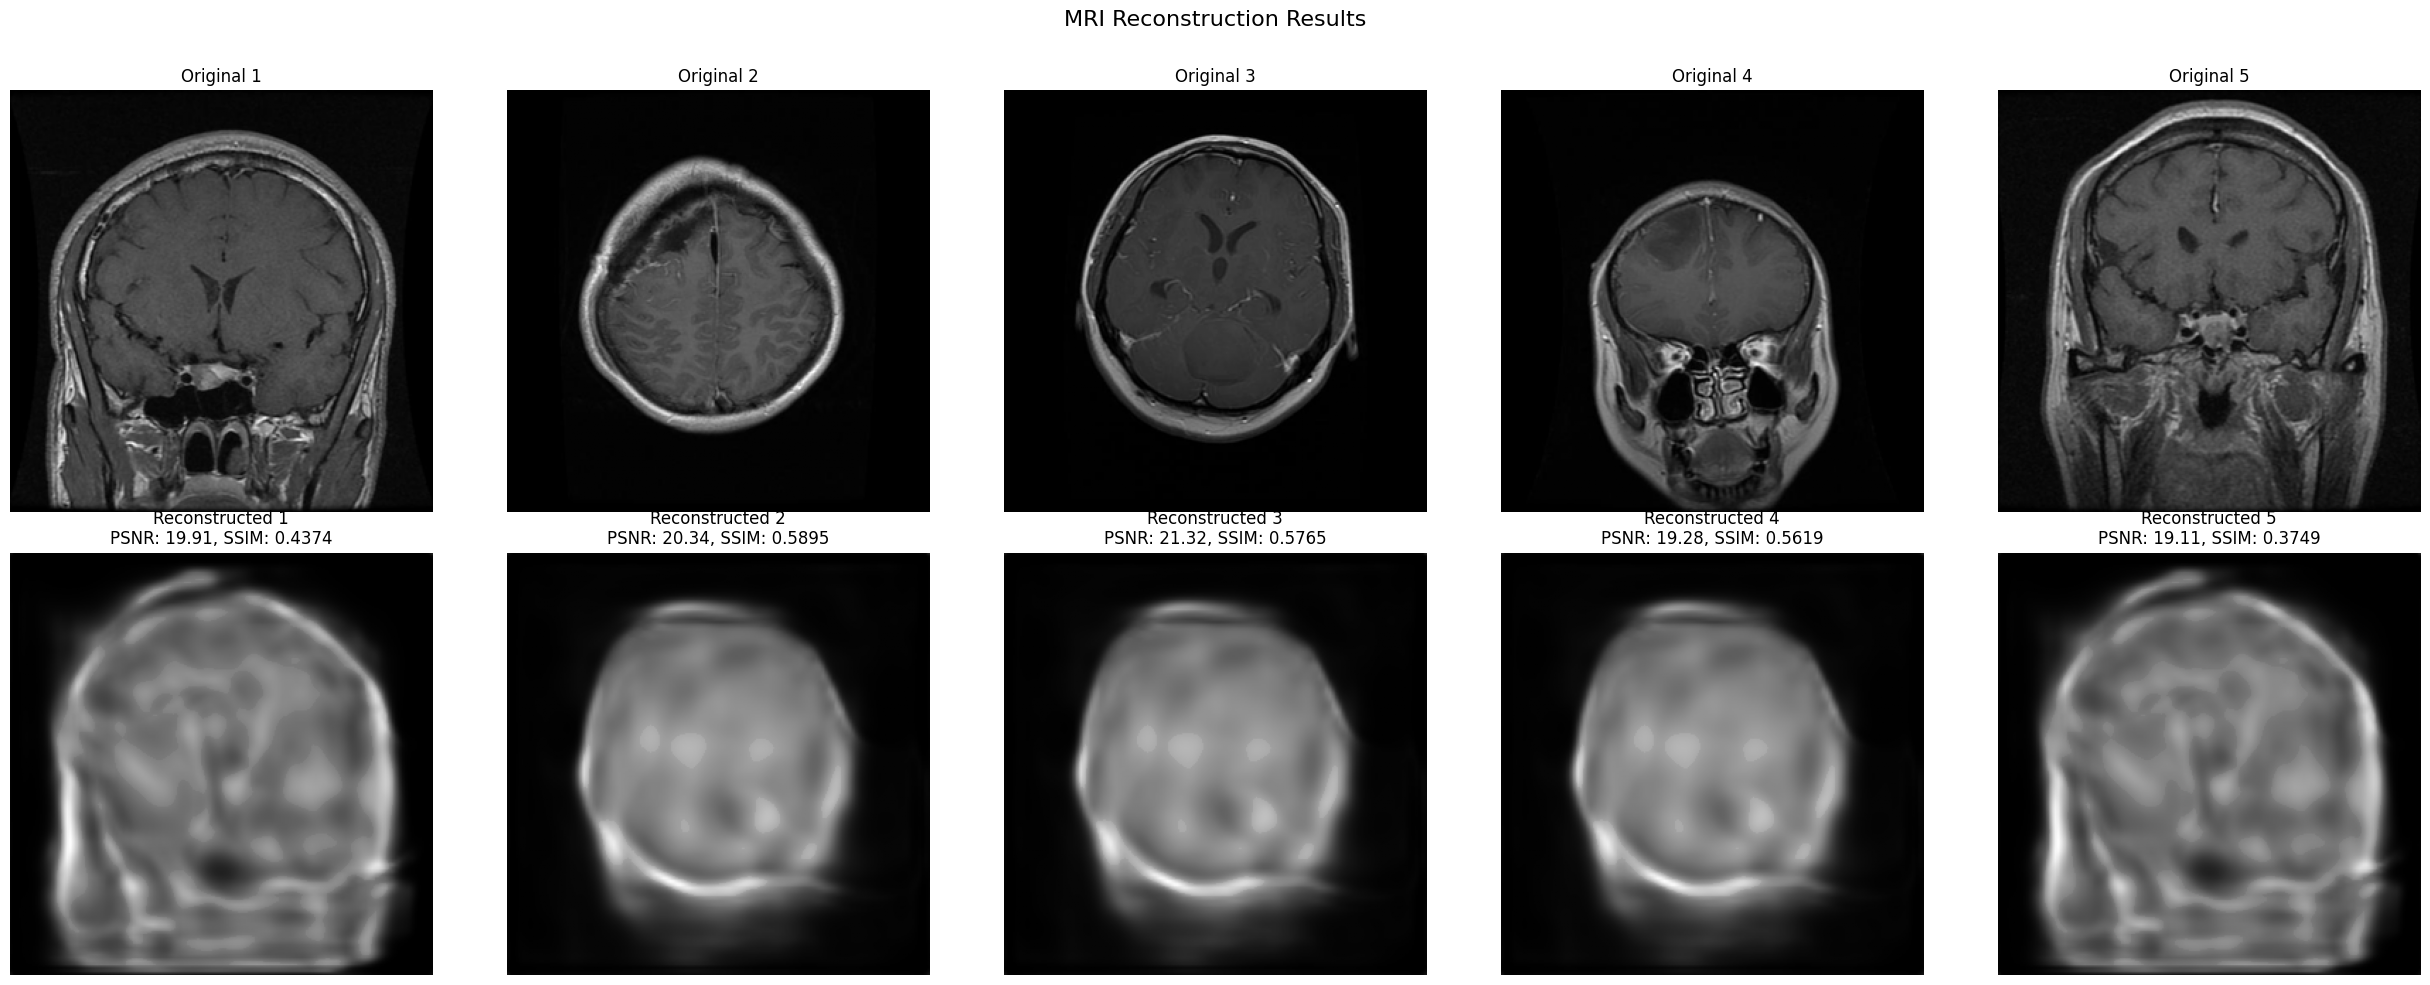

In [21]:
model_evaluation_global = evaluate_multiple_reconstructions(global_model, attack_model, test_loader, device)
visualize_multiple_reconstructions(model_evaluation_global)

### Client Models

In [22]:
try:
    device
except NameError:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

try:
    feature_extractor
except NameError:
    feature_extractor = MRIFeatureExtractor().to(device)


for original_images, _ in test_loader:
    original_images = original_images.to(device)
    break

# Load client models for attack
client_models = []
for i in range(3):  # Assuming 3 clients
    try:
        client_model = load_client_model(i, path=f'/content/drive/MyDrive/Spring 25/github_brainfl/pretrained_models/client_{i}_model.pth')
        client_models.append((i, client_model))
    except:
        print(f"Could not load client {i} model")

num_samples = 5
client_reconstructed = []
client_metrics = []

for client_idx, client_model in client_models:
    print(f"\nRunning independent MRI-focused attack on Client {client_idx+1} model...")

    # Create fresh attack model for each client
    client_attack_model = AttackModel(current_size=32).to(device)

    # Run full training process from scratch
    client_images = run_mri_focused_attack(
        client_model,
        client_attack_model,
        test_loader,
        feature_extractor,
        device,
        training_epochs=25,  # Full epochs since starting from scratch
        start_size=32,
        final_size=299
    )

    # Evaluate with comprehensive metrics
    for images, _ in test_loader:
        original_images = images.to(device)
        break

    comprehensive_metrics = evaluate_mri_reconstruction(
        original_images, client_images[:original_images.size(0)]
    )

    # Store results
    client_reconstructed.append((client_idx, client_images))
    client_metrics.append((client_idx,
                        comprehensive_metrics['MSE'],
                        comprehensive_metrics['PSNR'],
                        comprehensive_metrics['SSIM'],
                        comprehensive_metrics['Structure_Score']))

    # Report results
    print(f"Client {client_idx+1} Metrics: PSNR={comprehensive_metrics['PSNR']:.2f}, "
          f"SSIM={comprehensive_metrics['SSIM']:.4f}")

    # Visualize multiple images
    metrics_list = []
    for i in range(min(num_samples, len(original_images), len(client_images))):
        img_metrics = evaluate_mri_reconstruction(
            original_images[i:i+1],
            client_images[i:i+1]
        )
        metrics_list.append(img_metrics)

    multi_results = {
        'original': original_images[:num_samples],
        'reconstructed': client_images[:num_samples],
        'metrics': metrics_list
    }

    visualize_multiple_reconstructions(
        multi_results, title=f"Client {client_idx+1} MRI Reconstruction Results"
    )

    # Clean up completely to ensure no information leakage between clients
    del client_attack_model
    torch.cuda.empty_cache()
    gc.collect()

Output hidden; open in https://colab.research.google.com to view.